<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea3_MLA/blob/main/Tarea_3_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla</em><br>

</div>

# **Machine Learning Avanzado: Tarea N°3**
*17 de diciembre de 2024*

Integrantes:

- Julio Assmann
- Diego León
- Sofía Vits

## Introducción

# Objetivos

## Metodología

In [1]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import random
import kagglehub
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as adfuller
import ruptures as rpt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

## Modelos

### Autoencoder

#### Carga de datos

In [3]:
from google.colab import files
uploaded = files.upload()

Saving denoising-dirty-documents.zip to denoising-dirty-documents.zip


In [4]:
!unzip denoising-dirty-documents.zip
!unzip train.zip
!unzip train_cleaned.zip
!unzip test.zip

Archive:  denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       
Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  infl

In [5]:
!ls

denoising-dirty-documents.zip  sampleSubmission.csv.zip  test.zip  train_cleaned      train.zip
sample_data		       test			 train	   train_cleaned.zip


In [6]:
import cv2
import os
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))

    return img

X_train = []
y_train = []
X_test = []

for f in sorted(os.listdir('train/')):
    X_train.append(process_image('train/' + f))

for f in sorted(os.listdir('train_cleaned/')):
    y_train.append(process_image('train_cleaned/' + f))

for f in sorted(os.listdir('test/')):
    X_test.append(process_image('test/' + f))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)

#### Exploración de datos

In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (144, 420, 540, 1)
X_test shape: (72, 420, 540, 1)


Función para mostrar imágenes de ejemplo

In [8]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Convertir ax a una lista, incluso si es un único objeto
    if n_rows == 1 or n_cols == 1:
        ax = np.array(ax).flatten()
    else:
        ax = ax.flatten()

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx])
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


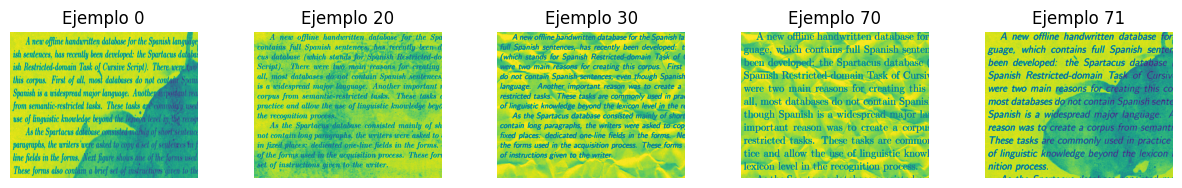

In [9]:
example_idx = [0, 20, 30, 70, 71]
filtered_images = [X_test[img_idx]/255 for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]

plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

#### Modelo autoencoder y entrenamiento

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42)

In [11]:
class ConvAutoEncoder(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),
            Dropout(0.5)
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - loss: 0.0720 - mse: 0.2064 - val_loss: 0.0626 - val_mse: 0.1782
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 649ms/step - loss: 0.0565 - mse: 0.1624 - val_loss: 0.0438 - val_mse: 0.1205
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 651ms/step - loss: 0.0374 - mse: 0.1020 - val_loss: 0.0315 - val_mse: 0.0742
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 648ms/step - loss: 0.0284 - mse: 0.0668 - val_loss: 0.0318 - val_mse: 0.0710
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 661ms/step - loss: 0.0288 - mse: 0.0653 - val_loss: 0.0314 - val_mse: 0.0697
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 655ms/step - loss: 0.0280 - mse: 0.0633 - val_loss: 0.0295 - val_mse: 0.0666
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 665ms/step - loss: 0.0266 - mse: 0.0617 - val_loss: 0.0284 - val_mse: 0.0661
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 664ms/step - loss: 0.0255 - mse: 0.0600 - val_loss: 0.0267 - val_mse: 0.0600
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 666ms/step - loss: 0.0238 - 

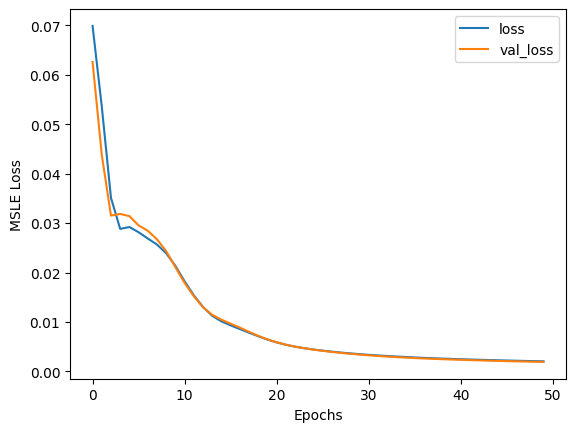

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

image_size=(420, 540)
model = ConvAutoEncoder(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

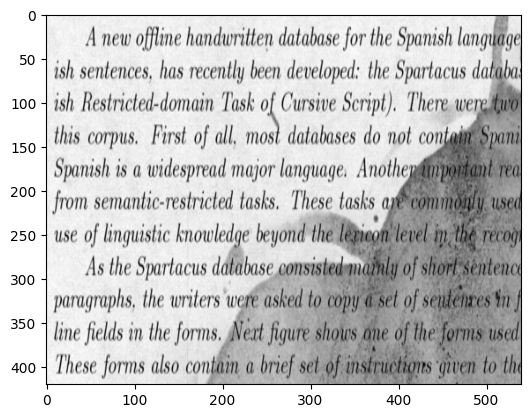

In [ ]:
plt.imshow(X_test[0, :, :, :], cmap = 'gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


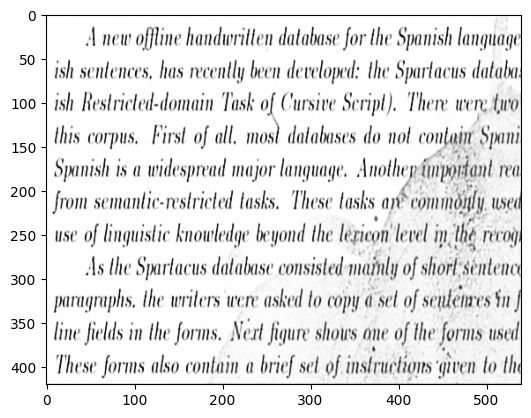

In [ ]:
y_pred_ae = model.predict(X_test[0:5, :, :, :])
plt.imshow(y_pred_ae[0, :, :, :], cmap='gray')

### LSTM

### Análisis producción de leche entre los años 1962 y 1975

In [ ]:
df_leche = pd.read_csv('monthly_milk_production.csv')

In [ ]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [ ]:
df_leche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
df_leche.shape

(168, 2)

In [ ]:
df_leche.isnull().sum()

,0
Date,0
Production,0


In [ ]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


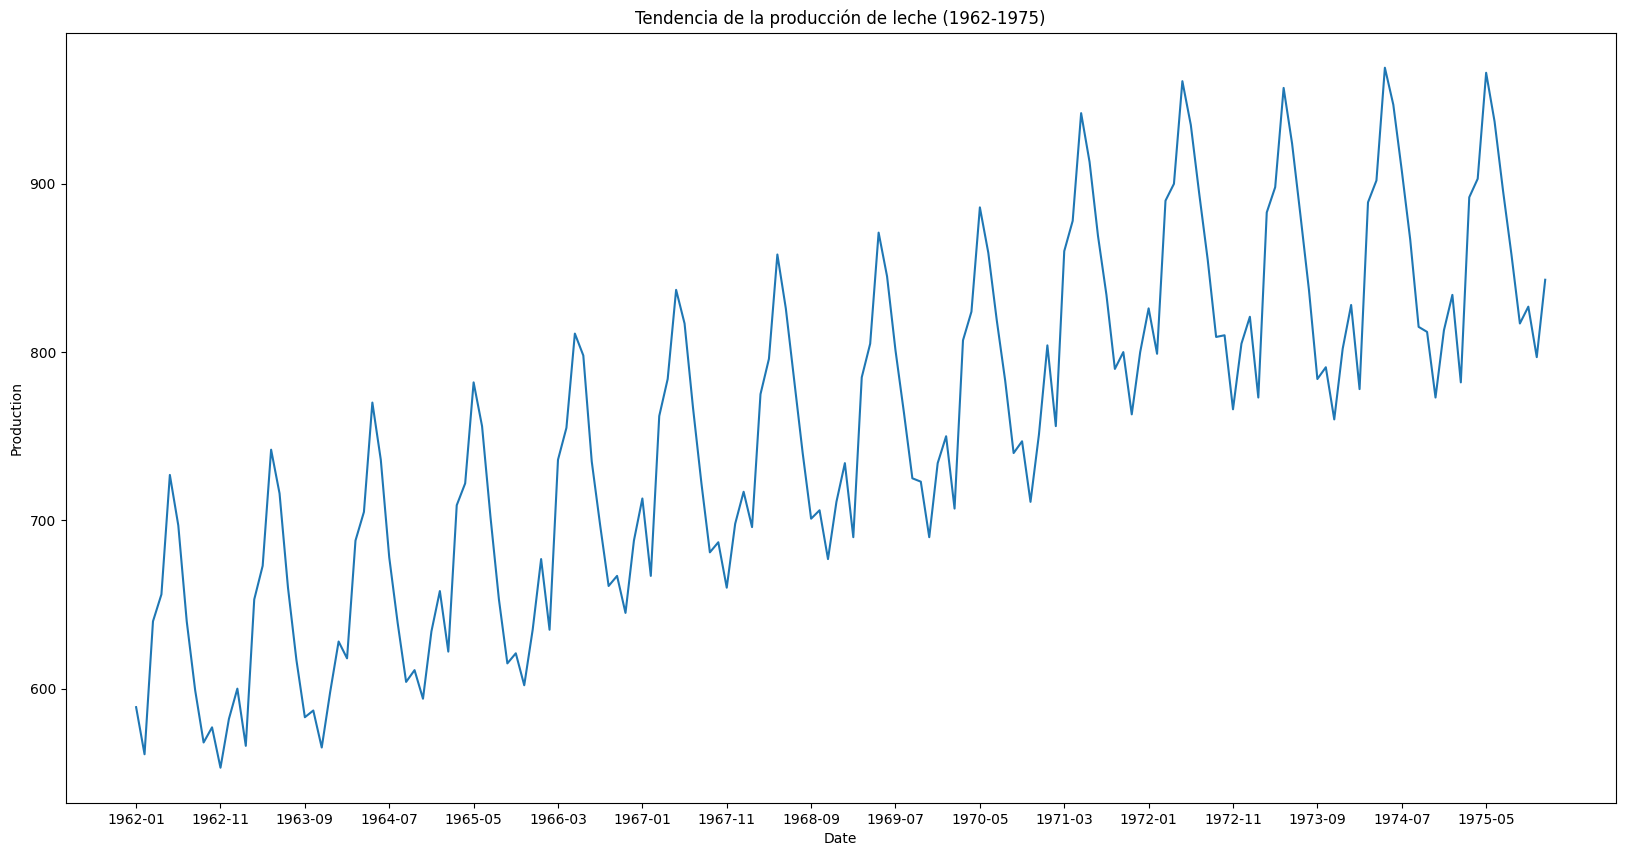

In [ ]:
# Análisis temporal: Cambios de "Production" a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=df_leche, x='Date', y='Production')
plt.title('Tendencia de la producción de leche (1962-1975)')
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

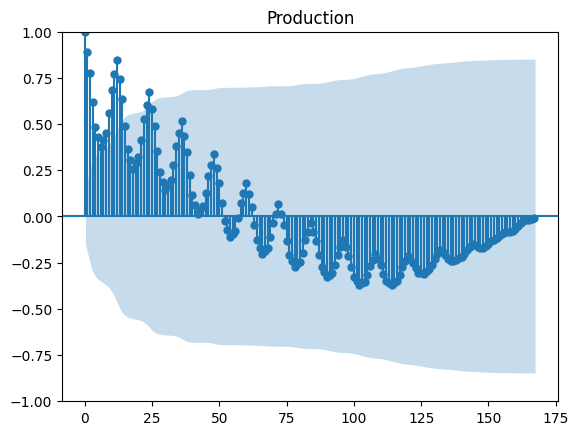

In [ ]:
# Autocorrelation
plot_acf(df_leche['Production'], lags=167, title='Production', alpha = 0.05)
plt.show()

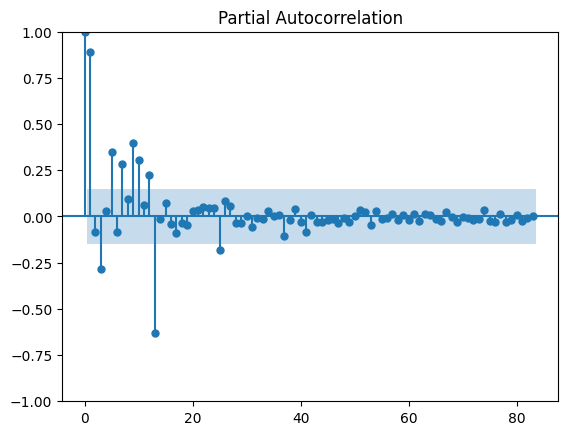

In [ ]:
# Partial Autocorrelation
plot_pacf(df_leche['Production'], lags=83)
plt.show()

**Estacionariedad:**

Corresponde a una propiedad clave en el análisis de series temporales. Una serie temporal se considera `estacionaria`si sus propiedades estadísticas, como la media y la varianza, son constantes en el tiempo. En términos prácticos, una serie estacionaria no tiene tendencia ni estacionalidad, y cualquier cambios observado en la serie es puramente ruido aleatorio.

Para verificar si una serie temporal es estacionaria o no, una de las pruebas más utilizadas es la Prueba de **Dickey-Fuller Aumentada (ADF)**.

Esta prueba tiene las siguientes hipótesis:

**Hipótesis nula (H₀):** La serie tiene una raíz unitaria (es decir, la serie no es estacionaria).

**Hipótesis alternativa (H₁):** La serie es estacionaria.

Si el valor `p` de la prueba es menor a un nivel de significancia, como `0.05`, se rechaza la hipótesis nula y podemos concluir que la serie es estacionaria.

In [ ]:
adf_result = sts.adfuller(df_leche['Production'])

# Extraer los resultados claves
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Mostrar los resultados de la prueba ADF
adf_statistic, p_value, critical_values

(-1.3038115874221308,
 0.6274267086030311,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677})

Los resultados de la prueba de **Dickey-Fuller Aumentada (ADF)** para la variable **Production** son los siguientes:

- **Estadístico ADF:** resultado -1.30, cuanto más negativo sea este valor más probable es que la serie sea estacionaria. Si el estadístico ADF es menor (más negativo) que los valores críticos, se puede rechazar la hipótesis nula y concluir que la serie es estacionaria. En este caso, el valor de -1.30 no es lo suficientemente negativo para superar los valores críticos, lo que sugiere que la serie no es estacionaria.

- **Valor p:** resultado 0.63, esto significa que al ser mayor que el nivel de significancia comúnmente utilizado (0.05, o 5%), no se podría rechazar la hipótesis nula donde se establece que la serie tiene una raíz unitaria. Esto quiere decir, que la prueba sugiere que la serie `no es estacionaria`.

- **Valores críticos:**

    1% -> -3.47 El 1% respresenta un valor crítico muy conservador, lo cual quiere decir que si el estadístico ADF es menor que este valor, hay evidencia muy fuerte que la serie es estacionaria.

    5% -> -2.88 El 5% es un valor conmúnmente utilizado. Si el estadístico ADF es menor que este valor, podemos concluir que la serie es estacionaria.

    10% -> -2.58 El 10% es el valor máximo. En este caso, si el estadístico ADF es menor que este valor, la serie es estacionaria, pero menos convincente.


**En conclusión, gracias a los valores obtenidos mediante la prueba ADF, podemos indicar que la variable Production no presenta estacionariedad**

Puntos de quiebre detectados: [50, 110, 168]


<Figure size 1000x600 with 0 Axes>

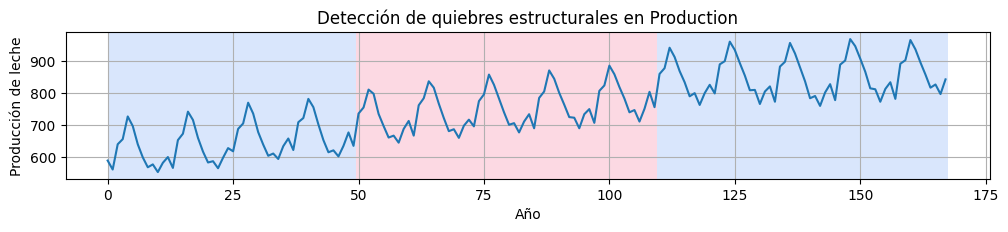

In [ ]:
# Convertir los datos a formato de numpy para aplicar la detección de quiebres
signal = df_leche['Production'].values

# Crear un modelo para detectar quiebres (usando el método de cambios de media)
algo = rpt.Pelt(model="rbf").fit(signal)

# Definir un valor para penalización (esto determina la sensibilidad para detectar quiebres)
pen = 10

# Identificar quiebres
breakpoints = algo.predict(pen=pen)

# Mostrar los puntos donde se detectaron quiebres
print("Puntos de quiebre detectados:", breakpoints)

# Visualizar los quiebres detectados
plt.figure(figsize=(10, 6))
rpt.display(signal, breakpoints)
plt.title('Detección de quiebres estructurales en Production')
plt.xlabel('Año')
plt.ylabel('Producción de leche')
plt.grid(True)
plt.show()

In [ ]:
df_leche["Date"] = df_leche['Date'].str.replace('-', '')

In [ ]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(split_percent=0.8):
    df = df_leche
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Production')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


Epoch 1/30
22/22 - 6s - 263ms/step - loss: 0.0728
Epoch 2/30
22/22 - 2s - 94ms/step - loss: 0.0189
Epoch 3/30
22/22 - 0s - 6ms/step - loss: 0.0060
Epoch 4/30
22/22 - 0s - 6ms/step - loss: 0.0074
Epoch 5/30
22/22 - 0s - 6ms/step - loss: 0.0064
Epoch 6/30
22/22 - 0s - 6ms/step - loss: 0.0061
Epoch 7/30
22/22 - 0s - 5ms/step - loss: 0.0070
Epoch 8/30
22/22 - 0s - 6ms/step - loss: 0.0057
Epoch 9/30
22/22 - 0s - 5ms/step - loss: 0.0083
Epoch 10/30
22/22 - 0s - 5ms/step - loss: 0.0065
Epoch 11/30
22/22 - 0s - 5ms/step - loss: 0.0072
Epoch 12/30
22/22 - 0s - 5ms/step - loss: 0.0048
Epoch 13/30
22/22 - 0s - 4ms/step - loss: 0.0054
Epoch 14/30
22/22 - 0s - 6ms/step - loss: 0.0042
Epoch 15/30
22/22 - 0s - 6ms/step - loss: 0.0052
Epoch 16/30
22/22 - 0s - 4ms/step - loss: 0.0040
Epoch 17/30
22/22 - 0s - 4ms/step - loss: 0.0044
Epoch 18/30
22/22 - 0s - 6ms/step - loss: 0.0038
Epoch 19/30
22/22 - 0s - 4ms/step - loss: 0.0040
Epoch 20/30
22/22 - 0s - 4ms/step - loss: 0.0035
Epoch 21/30
22/22 - 0s - 4

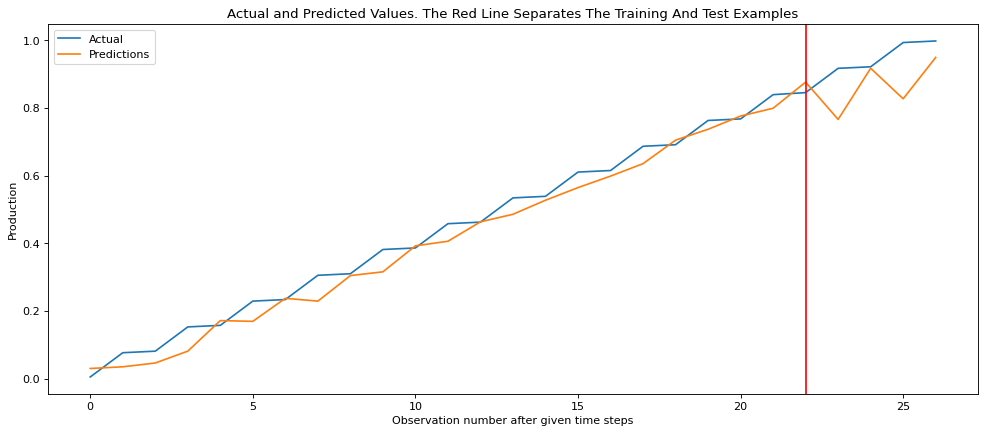

In [ ]:
time_steps = 12
train_data, test_data, data = get_train_test()
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Create model and train
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

## Análisis de resultados

## Conclusiones

### Análisis IPSA 1989 a la Fecha


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
# Cargar archivo
from google.colab import files
import io
# Cargar archivo desde la máquina local
uploaded2 = files.upload()

# Leer el archivo cargado
file_path = list(uploaded2.keys())[0]
data = pd.read_excel(io.BytesIO(uploaded2[file_path]), sheet_name='Cuadro')

Saving IPSA 1989-2024 Banco Central.xlsx to IPSA 1989-2024 Banco Central (3).xlsx


In [10]:
data_cleaned = data.iloc[2:].reset_index(drop=True)
data_cleaned.columns = ['Periodo', 'IPSA']
data_cleaned = data_cleaned[['Periodo', 'IPSA']]
data_cleaned['Periodo'] = pd.to_datetime(data_cleaned['Periodo'], errors='coerce')
data_cleaned['IPSA'] = pd.to_numeric(data_cleaned['IPSA'], errors='coerce')

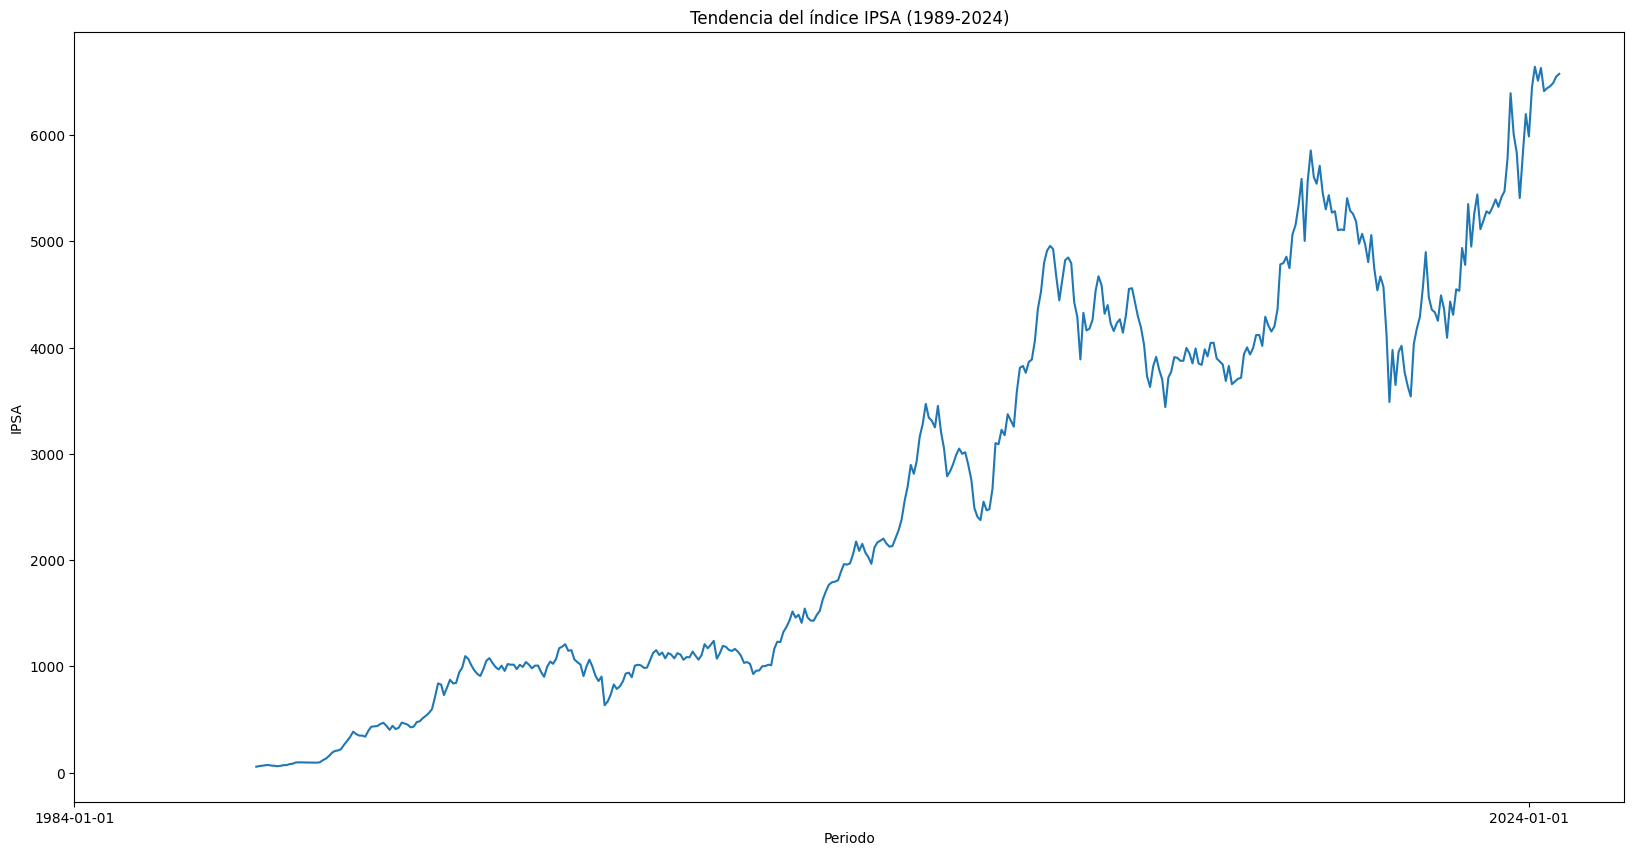

In [11]:
# Gráfico EDA: Tendencia del IPSA a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=data_cleaned, x='Periodo', y='IPSA')
plt.title('Tendencia del índice IPSA (1989-2024)')
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

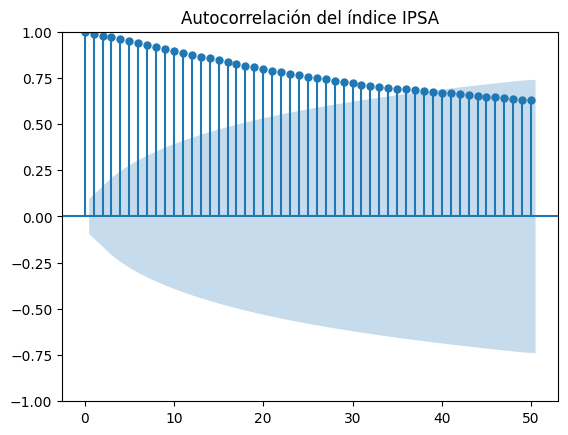

In [12]:
# Gráfico EDA: Autocorrelación del IPSA
plot_acf(data_cleaned['IPSA'], lags=50, title='Autocorrelación del índice IPSA', alpha=0.05)
plt.show()

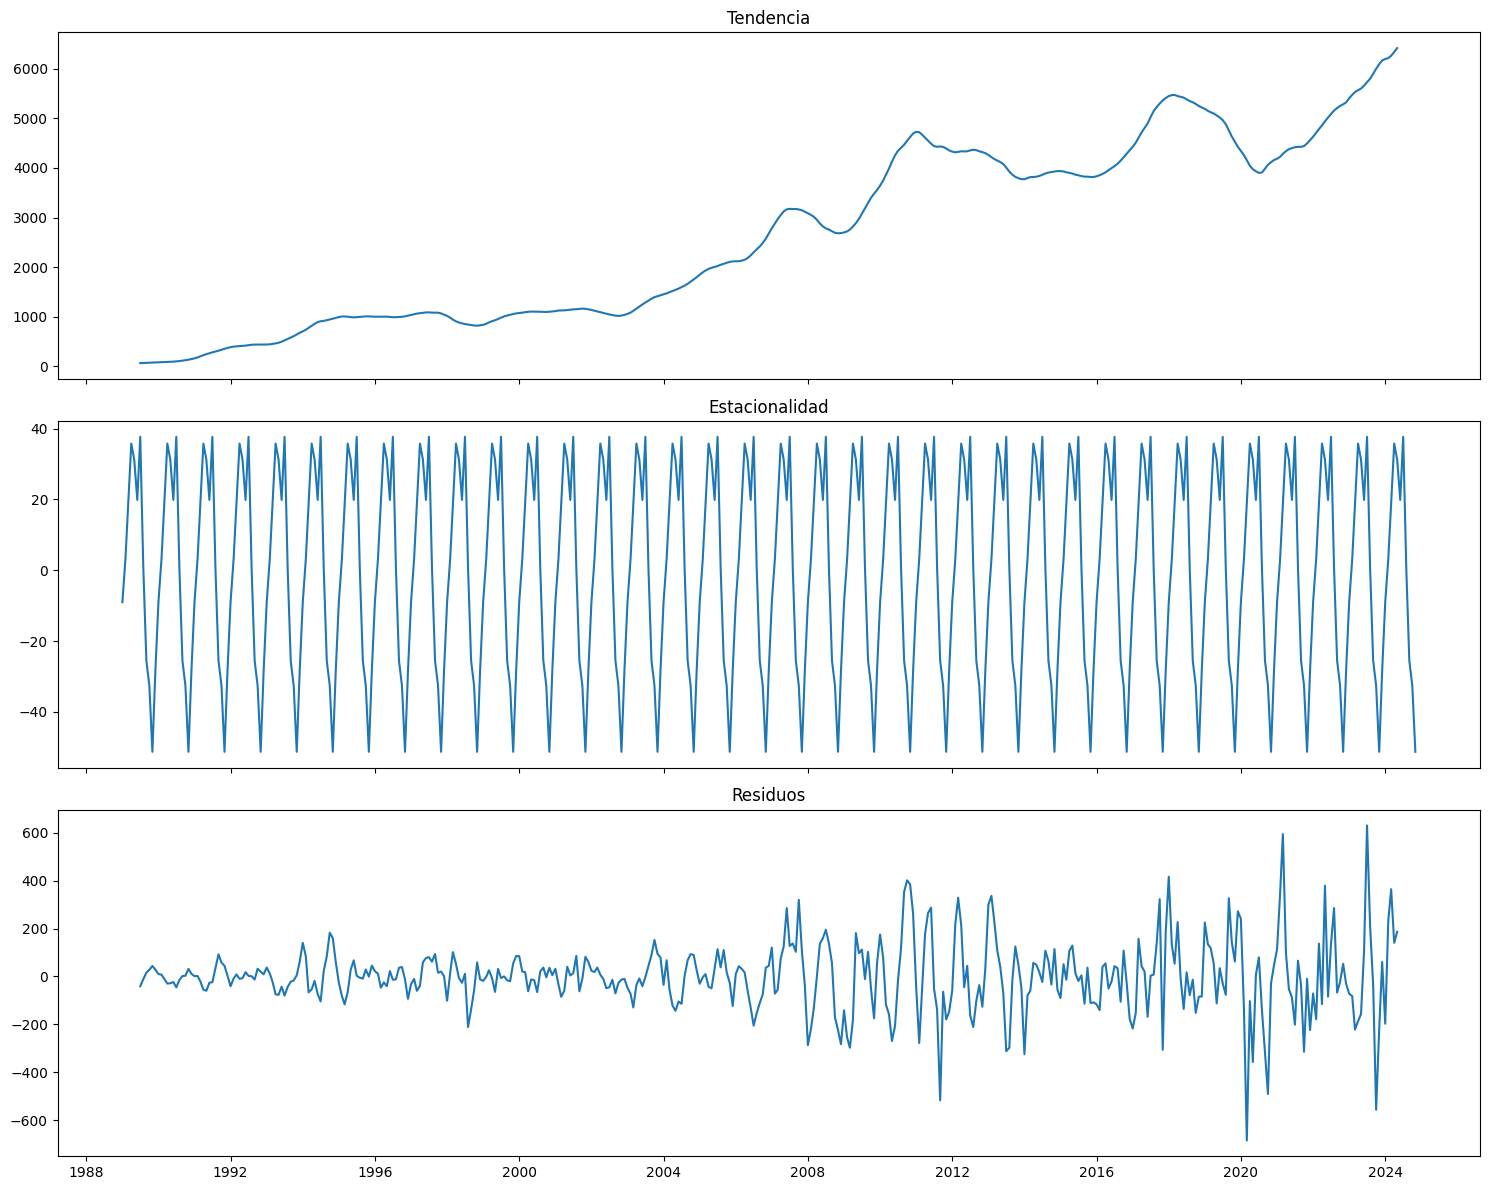

In [13]:
# Descomposición estacional
decomposition = seasonal_decompose(data_cleaned['IPSA'], model='additive', period=12)
data_cleaned['Trend'] = decomposition.trend
data_cleaned['Seasonal'] = decomposition.seasonal
data_cleaned['Residual'] = decomposition.resid

# Gráfico de descomposición
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axs[0].plot(data_cleaned['Periodo'], data_cleaned['Trend'], label='Trend')
axs[0].set_title('Tendencia')
axs[1].plot(data_cleaned['Periodo'], data_cleaned['Seasonal'], label='Seasonality')
axs[1].set_title('Estacionalidad')
axs[2].plot(data_cleaned['Periodo'], data_cleaned['Residual'], label='Residual')
axs[2].set_title('Residuos')
plt.tight_layout()
plt.show()

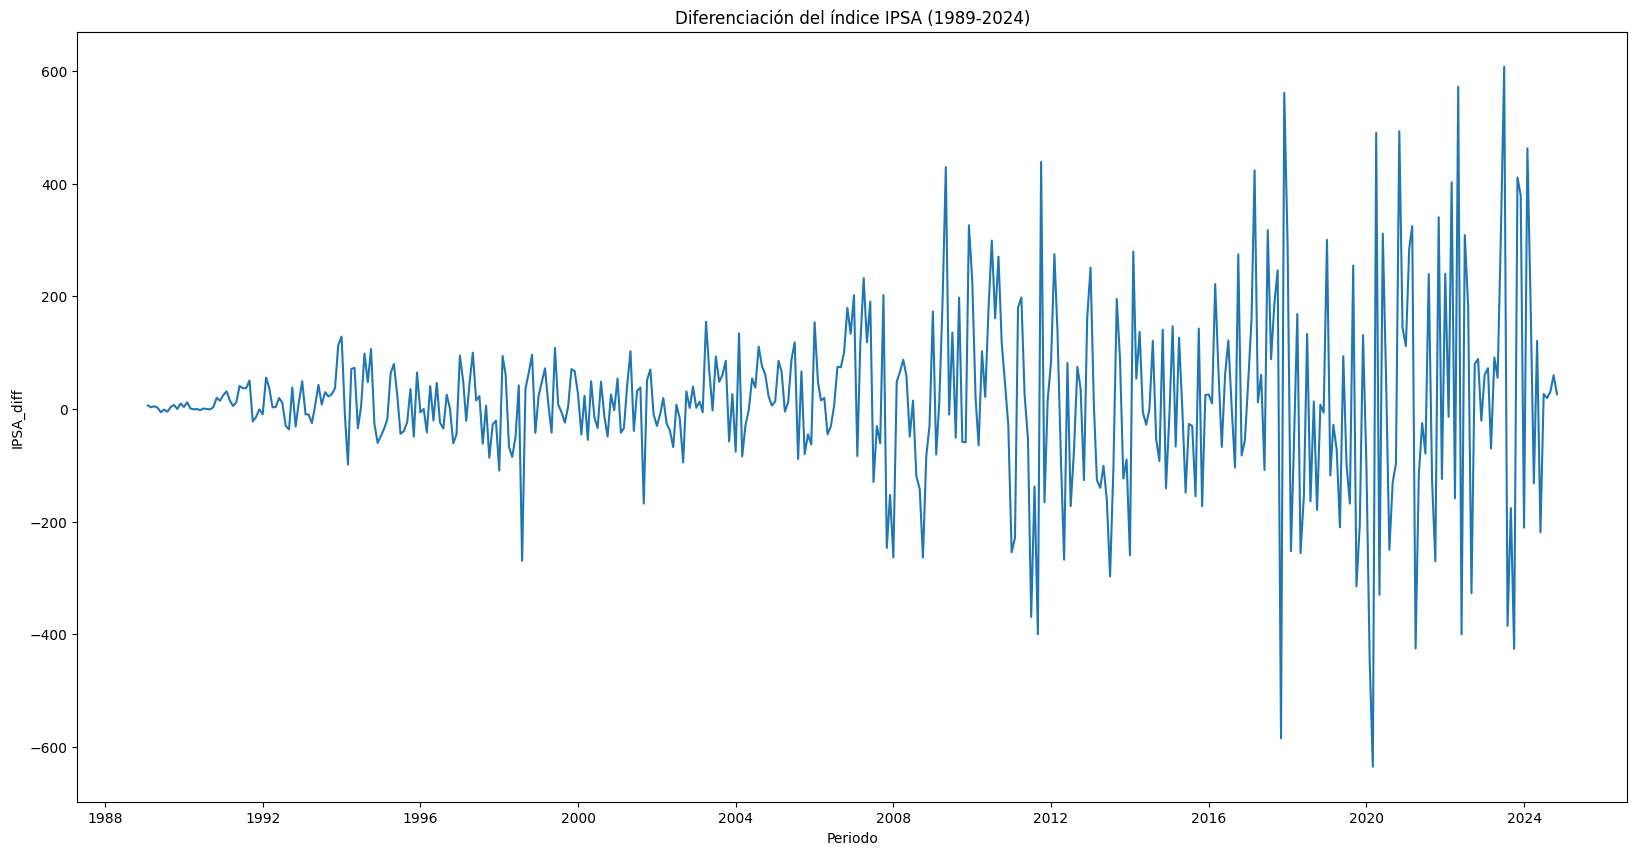

In [14]:
# Diferenciación para reducir autocorrelación
data_cleaned['IPSA_diff'] = data_cleaned['IPSA'].diff().dropna()

# Gráfico de datos diferenciados
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=data_cleaned, x='Periodo', y='IPSA_diff')
plt.title('Diferenciación del índice IPSA (1989-2024)')
plt.show()

# Normalización de los valores del IPSA diferenciados
scaler = MinMaxScaler(feature_range=(0, 1))
# Crear una columna vacía para normalizar solo los valores no nulos
data_cleaned['IPSA_diff_normalized'] = np.nan
non_na_indices = data_cleaned['IPSA_diff'].notna()

# Normalizar solo los valores no nulos
data_cleaned.loc[non_na_indices, 'IPSA_diff_normalized'] = scaler.fit_transform(
    data_cleaned.loc[non_na_indices, ['IPSA_diff']]
)

# Crear ventanas de tiempo para GRU
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.1873 - val_loss: 0.0899
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0365 - val_loss: 0.0592
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0261 - val_loss: 0.0486
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0138 - val_loss: 0.0481
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.0487
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - val_loss: 0.0478
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0146 - val_loss: 0.0478
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0119 - val_loss: 0.0476
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.0473
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - val_loss: 0.0471
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0462 
Loss en el conjunto de prueba: 0.047106705605983734
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


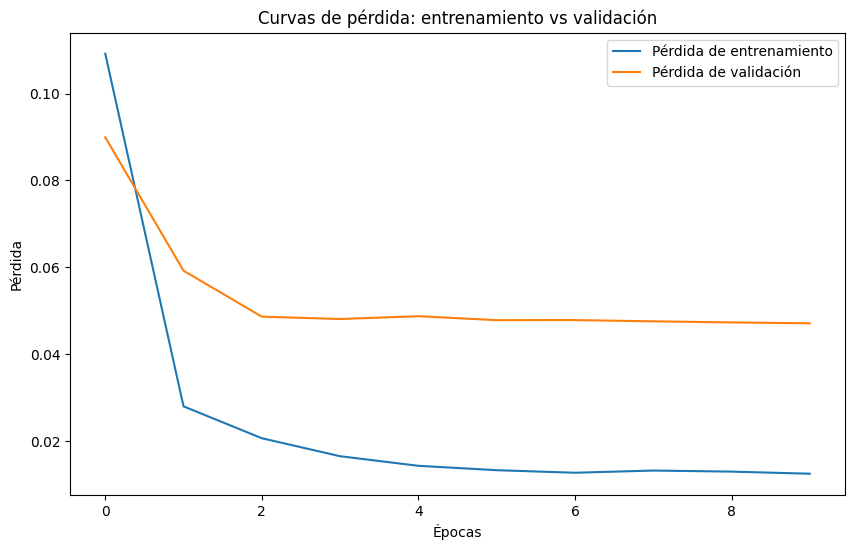

RMSE: 0.21704080380808638
MAE: 0.17112243800754876


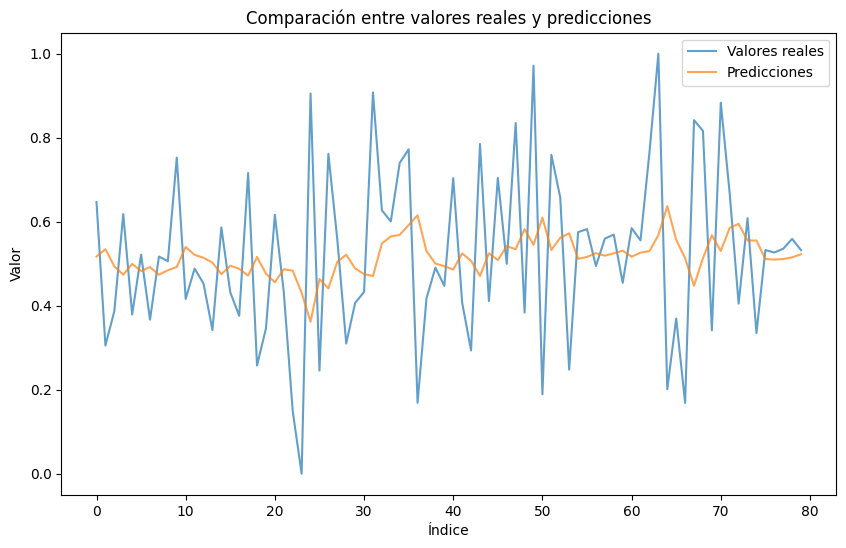

In [15]:
data_values = data_cleaned['IPSA_diff_normalized'].dropna().values
X, y = create_sequences(data_values, sequence_length)

# Dividir en conjuntos de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Añadir una tercera dimensión a los datos de entrada
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construcción del modelo Bidirectional GRU
model = Sequential([
    Bidirectional(GRU(50, return_sequences=True, input_shape=(sequence_length, 1))),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {loss}")

# Predicciones
predictions = model.predict(X_test)

# Gráficos de pérdidas: entrenamiento vs validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida: entrenamiento vs validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Calcular métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Comparación de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reales', alpha=0.7)
plt.plot(predictions, label='Predicciones', alpha=0.7)
plt.title('Comparación entre valores reales y predicciones')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Guardar resultados
results = pd.DataFrame({
    'Fecha': data_cleaned['Periodo'].iloc[sequence_length + split:sequence_length + split + len(y_test)].values,
    'Real': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
    'Predicción': scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
})


In [16]:
# Predicción de los próximos 3 meses
last_sequence = X_test[-1].reshape(1, sequence_length, 1)
future_predictions = []
for _ in range(3):
    next_prediction = model.predict(last_sequence)[0, 0]
    future_predictions.append(next_prediction)
    next_input = np.append(last_sequence[:, 1:, :], np.expand_dims([[next_prediction]], axis=2), axis=1)
    last_sequence = next_input

future_predictions_real = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten() + data_cleaned['IPSA'].iloc[-1]


# Crear un DataFrame para los resultados futuros
future_dates = pd.date_range(start=data_cleaned['Periodo'].iloc[-1], periods=4, freq='M')[1:]
future_results = pd.DataFrame({
    'Periodo': future_dates,
    '1.IPSA (índice enero 2003=1000)': future_predictions_real
})

# Mostrar resultados ajustados
from IPython.display import display
print("Resultados Futuros Ajustados:")
display(future_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Resultados Futuros Ajustados:


<ipython-input-16-137935245c4d>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=data_cleaned['Periodo'].iloc[-1], periods=4, freq='M')[1:]


,Periodo,1.IPSA (índice enero 2003=1000)
0,2024-12-31,6590.988281
1,2025-01-31,6590.593262
2,2025-02-28,6589.388184
